In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout, RandomContrast, RandomBrightness
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# What are the options:

- Building our own model
    - might be difficult to reach the accuracy of models trained on millions of image
    - Training a full model is time consuming
- Re-using a premaid model
    - Many different model to choose from VGG16, ResNet, or Inception... 
    - Saving time and we already have a proof of concept 

**We will go with the VGG16 transfer learning approach**

To make it better we will also use Data augmentation directly in the model as a layer

In [47]:
#helper function

def get_variable_name(var):
    """
    Retrieve the variable name as a string from a global variable.
    """
    global_vars = globals()
    for name, value in global_vars.items():
        if value is var:
            return name
    return None

In [48]:
image_categ = pd.read_csv('U://DATA/OpenClassrooms/Data science/P6/Flipkart/image_data.csv')

path = 'U://DATA/OpenClassrooms/Data science/P6/Flipkart/Images/'
list_photos = [path + img for img in image_categ['image_name']]
print(len(list_photos))

1050


In [49]:
image_categ['image_path'] = list_photos
image_categ.rename(columns={'category': 'label_name'}, inplace=True)
category_mapping = {
    'Home Furnishing': 0,
    'Baby Care': 1,
    'Watches': 2,
    'Home Decor & Festive Needs': 3,
    'Kitchen & Dining': 4,
    'Beauty and Personal Care': 5,
    'Computers': 6
}

image_categ['label'] = image_categ['label_name'].map(category_mapping)
image_categ

,label_name,image_name,image_path,label
0,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,U://DATA/OpenClassrooms/Data science/P6/Flipka...,0
1,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,U://DATA/OpenClassrooms/Data science/P6/Flipka...,1
2,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,U://DATA/OpenClassrooms/Data science/P6/Flipka...,1
3,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,U://DATA/OpenClassrooms/Data science/P6/Flipka...,0
4,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,U://DATA/OpenClassrooms/Data science/P6/Flipka...,0
...,...,...,...,...
1045,Baby Care,958f54f4c46b53c8a0a9b8167d9140bc.jpg,U://DATA/OpenClassrooms/Data science/P6/Flipka...,1
1046,Baby Care,fd6cbcc22efb6b761bd564c28928483c.jpg,U://DATA/OpenClassrooms/Data science/P6/Flipka...,1
1047,Baby Care,5912e037d12774bb73a2048f35a00009.jpg,U://DATA/OpenClassrooms/Data science/P6/Flipka...,1
1048,Baby Care,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,U://DATA/OpenClassrooms/Data science/P6/Flipka...,1


**Let's create our train, validation and test splits**

In [50]:
from sklearn.model_selection import train_test_split

# Split the data into a temporary training dataset and a test dataset.
# For example, to get a test set of 20% of the total data, use test_size=0.2
train_temp, test = train_test_split(image_categ, test_size=0.13, random_state=42)

# Now split the temporary training dataset into the final train and validation datasets.
# Here, the validation set will be 20% of the original dataset size.
# Since the temporary train set is 80% of the original data, we take 25% of it for validation to get 20% of the original data.
train, validation = train_test_split(train_temp, test_size=0.15, random_state=42)

print(len(train), len(validation), len(test))  # Should print something like 630 210 210 (depending on your data)


776 137 137


In [51]:
display(train['label'].value_counts(), validation['label'].value_counts(), test['label'].value_counts())

5    116
2    116
4    114
1    114
0    106
6    106
3    104
Name: label, dtype: int64

3    27
5    24
0    18
2    18
1    18
6    16
4    16
Name: label, dtype: int64

6    28
0    26
4    20
3    19
1    18
2    16
5    10
Name: label, dtype: int64

# Time to generate an input our model will be able to read
- For VGG16 the model expect 224/224 images
- we also need to use the preprocess_input function that VGG16 provides

In [52]:
def create_datasets(data):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    image_size = (224, 224)
    
    dataset = datagen.flow_from_dataframe(
        dataframe=data,
        x_col='image_path',
        y_col='label_name',
        target_size=image_size,
        class_mode='categorical',
        batch_size=20,
        shuffle=True,
        seed=42,
        subset='training',
    )
    
    return dataset



In [53]:
train_data = create_datasets(train)
validation_data = create_datasets(validation)
test_data = create_datasets(test)

Found 776 validated image filenames belonging to 7 classes.
Found 137 validated image filenames belonging to 7 classes.
Found 137 validated image filenames belonging to 7 classes.


# Let's talk about data augmentation

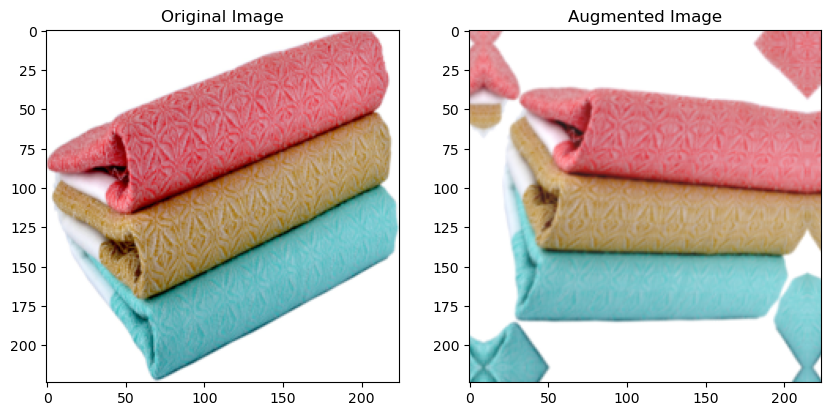

In [54]:
from PIL import Image

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1),
    RandomBrightness(0.1),
])

def show_augmentation(data_augmentation, image_path):
    # Load the image
    img = Image.open(image_path)
    img = img.resize((224, 224))  # Resize the image to the expected input size
    img_array = np.array(img)    

    # Apply the data augmentation
    augmented_img = data_augmentation(img_array, training= True)
   
    # Plot the original and augmented images
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    normalized_img = augmented_img / 255.0
    axs[0].imshow(img_array) 
    axs[0].set_title('Original Image')
    axs[1].imshow(normalized_img)  
    axs[1].set_title('Augmented Image')

show_augmentation(data_augmentation, image_categ['image_path'][1])


# Creating different models to try differents layers config

In [84]:
def create_model_fct():
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),
        RandomContrast(0.1),
        RandomBrightness(0.1)
    ])
    
    # VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False)
    
    
    base_model.trainable = False

    # let's add the data augmentation in the first layers, then the pre trained model, then our trainable last layers
    model = Sequential([
        data_augmentation,
        base_model,
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')  # last layer needs to have the same amout of channel as we have categories
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


def create_model_fct2():
    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),
        RandomContrast(0.1),
        RandomBrightness(0.1)
    ])

    # Load the VGG16 model, including the top (fully connected) layers
    base_model = VGG16(weights='imagenet', include_top=True)

    # Remove the last layer
    base_model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

    # Make the model non-trainable
    for layer in base_model.layers:
        layer.trainable = False

    # Now you can add your own custom layers
    model = Sequential([
        data_augmentation,
        base_model,
        Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)), # to help with over fitting
        Dropout(0.5), #ignore randomly some neurones also helps with over fitting
        Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(0.01))
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


def create_model_fct3(_train, _validation, _test):
    batch_size = 32

    # Data augmentation
    data_augmentation = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    
    train_data3 = data_augmentation.flow_from_dataframe(
                dataframe=_train,
                x_col='image_path',
                y_col='label_name',
                target_size=(224, 224),
                class_mode='categorical',
                batch_size=batch_size,)

    val_data3 = data_augmentation.flow_from_dataframe(
                dataframe=_validation,
                x_col='image_path',
                y_col='label_name',
                target_size=(224, 224),
                class_mode='categorical',
                batch_size=batch_size)
    
    test_data3 = data_augmentation.flow_from_dataframe(
                dataframe=_test,
                x_col='image_path',
                y_col='label_name',
                target_size=(224, 224),
                class_mode='categorical',
                batch_size=batch_size,
                shuffle=False)
    
    # Model architecture
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
    
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
    
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
    
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Model summary
    model.summary()
    return model, train_data3, val_data3, test_data3

In [87]:
model_VGG16_withoutTop = create_model_fct()

# Create the callback
model_VGG16_withoutTop_save_path = "./model1_best_weights.h5"

checkpoint = ModelCheckpoint(model_VGG16_withoutTop_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

callbacks_list1 = [checkpoint, es]

In [88]:
# Create the model
model2 = create_model_fct2()

# Create the callback
model2_save_path = "./model2_best_weights.h5"

checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

callbacks_list2 = [checkpoint, es]

In [79]:
model_noTL, train3, val3, test3 = create_model_fct3(train,validation,test)

# Create the callback
model_noTL_save_path = "./model3_best_weights.h5"

checkpoint = ModelCheckpoint(model_noTL_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

callbacks_list3 = [checkpoint, es]

Found 776 validated image filenames belonging to 7 classes.
Found 137 validated image filenames belonging to 7 classes.
Found 137 validated image filenames belonging to 7 classes.


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 111, 111, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 54, 54, 64)      

**Time to run the model**

In [72]:
def save_model_perf(history, model, training_time, batch_size):
    
    if os.path.isfile('U://DATA/OpenClassrooms/Data science/P6/saved_model_perf'):
        model_performance = pd.read_csv('U://DATA/OpenClassrooms/Data science/P6/saved_model_perf')
    else:
        model_performance = pd.DataFrame(columns=['Model', 'Training Time', 'Batch Size', 'Best Epoch', 'Best Val Loss', 'Best accuracy'])

    best_epoch = np.argmin(history.history['val_loss']) + 1  # epochs are 1-indexed
    best_val_loss = min(history.history['val_loss'])
    best_accuracy = history.history['accuracy'][best_epoch]


    new_row ={
        'Model': get_variable_name(model),  
        'Training Time': training_time,
        'Batch Size' : batch_size,
        'Best Epoch': best_epoch,
        'Best Val Loss': best_val_loss,
        'Best accuracy': best_accuracy,
    }
    new_row = pd.DataFrame([new_row])
    # Append the performance of the current model to the DataFrame
    checkfordupes = pd.concat([model_performance, new_row], ignore_index=True)
    duplicate_row = checkfordupes.duplicated(subset=['Model', 'Training Time']).any()

    if not duplicate_row:
                # Append the new row
                model_performance = model_performance.append(new_row, ignore_index=True)
                # Save the updated DataFrame to the file
                model_performance.to_csv('U://DATA/OpenClassrooms/Data science/P6/saved_model_perf', index=False)

    else: print("This model was already tried before")
    

    #save the df with the new row
    


    display(model_performance)
    return model_performance

In [92]:
#Choose which model and parameters to run
_batch_size = 64
_model = model2
_train_data = train_data
_validation_data = validation_data
_callback_list = callbacks_list2




start_time = time.time()

history = _model.fit(_train_data,
                    validation_data=_validation_data,
                    batch_size=_batch_size,
                    epochs=50, 
                    callbacks=_callback_list, 
                    verbose=1)

end_time = time.time()



# Calculate the total training time
training_time = end_time - start_time

model_perf = save_model_perf(history, model2, training_time, _batch_size)


Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 14.9434 - accuracy: 0.5979
Epoch 1: val_loss improved from inf to 11.36994, saving model to .\model2_best_weights.h5
39/39 [==============================] - 87s 2s/step - loss: 14.9434 - accuracy: 0.5979 - val_loss: 11.3699 - val_accuracy: 0.7810
Epoch 2/50
39/39 [==============================] - ETA: 0s - loss: 9.2588 - accuracy: 0.7487
Epoch 2: val_loss improved from 11.36994 to 8.24897, saving model to .\model2_best_weights.h5
39/39 [==============================] - 73s 2s/step - loss: 9.2588 - accuracy: 0.7487 - val_loss: 8.2490 - val_accuracy: 0.7226
Epoch 3/50
39/39 [==============================] - ETA: 0s - loss: 6.4943 - accuracy: 0.7899
Epoch 3: val_loss improved from 8.24897 to 6.12662, saving model to .\model2_best_weights.h5
39/39 [==============================] - 74s 2s/step - loss: 6.4943 - accuracy: 0.7899 - val_loss: 6.1266 - val_accuracy: 0.7664
Epoch 4/50
39/39 [==============================] -

C:\Users\jbgid\AppData\Local\Temp\ipykernel_19176\1756765810.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance = model_performance.append(new_row, ignore_index=True)


,Model,Training Time,Batch Size,Best Epoch,Best Val Loss,Best accuracy
0,model2,1326.496832,32,16,1.878372,0.867268
1,model_noTL,499.160741,32,10,1.624164,0.389175
2,_model,420.933123,32,2,13.971095,0.780928
3,_model,396.793299,10,2,31.542377,0.882732
4,_model,398.772818,64,2,53.673672,0.916237
5,model2,1488.361972,64,17,1.774744,0.850515


# Models analytics

In [74]:
def evaluate_last_epoch(model, _train_data, _validation_data):
    loss, accuracy = model.evaluate(_train_data, verbose=True)
    print("Training Accuracy   : {:.4f}".format(accuracy))
    print()
    loss, accuracy = model.evaluate(_validation_data, verbose=True)
    print("Validation Accuracy :  {:.4f}".format(accuracy))
    return


def evaluate_best_epoch(model, best_weight_path, _validation_data, _test_data):
    model.load_weights(best_weight_path)

    loss, accuracy = model.evaluate(_validation_data, verbose=False)
    print("Validation Accuracy :  {:.4f}".format(accuracy))

    loss, accuracy = model.evaluate(_test_data, verbose=False)
    print("Test Accuracy       :  {:.4f}".format(accuracy))
    return


def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

In [93]:
evaluate_best_epoch(model2, model2_save_path, validation_data, test_data)

Validation Accuracy :  0.8248


c:\ProgramData\Anaconda3\envs\Tensorflow\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Test Accuracy       :  0.8029


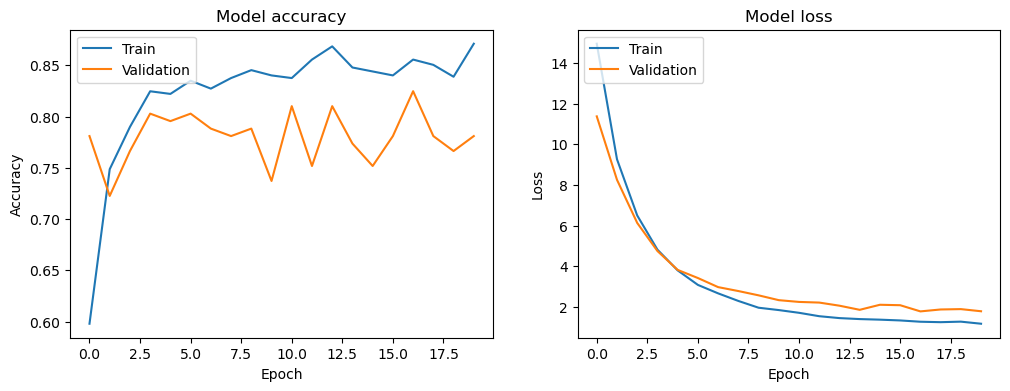

In [94]:
plot_history(history)